In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import integrate
import pandas as pd
from functools import partial
import models

# Férec Model  
Ref: Férec, et. al. “Modeling fiber interactions in semiconcentrated fiber suspensions.” _J. Rheol._ **2009**, 53, 49–72.

<Axes: title={'center': 'simple shear'}, xlabel='time(s)'>

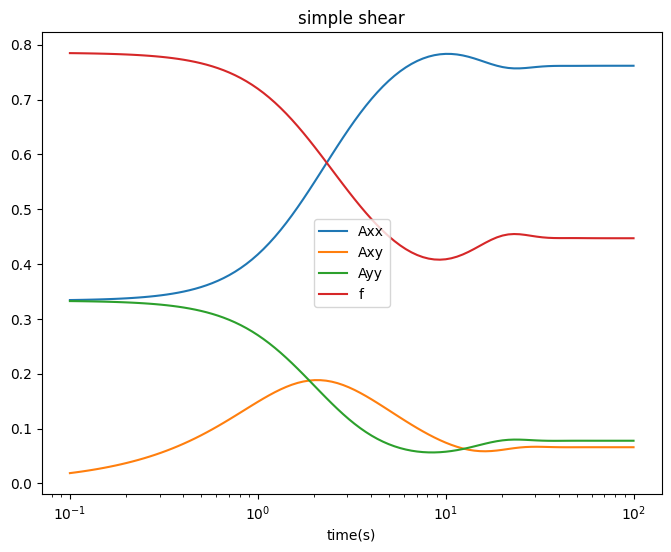

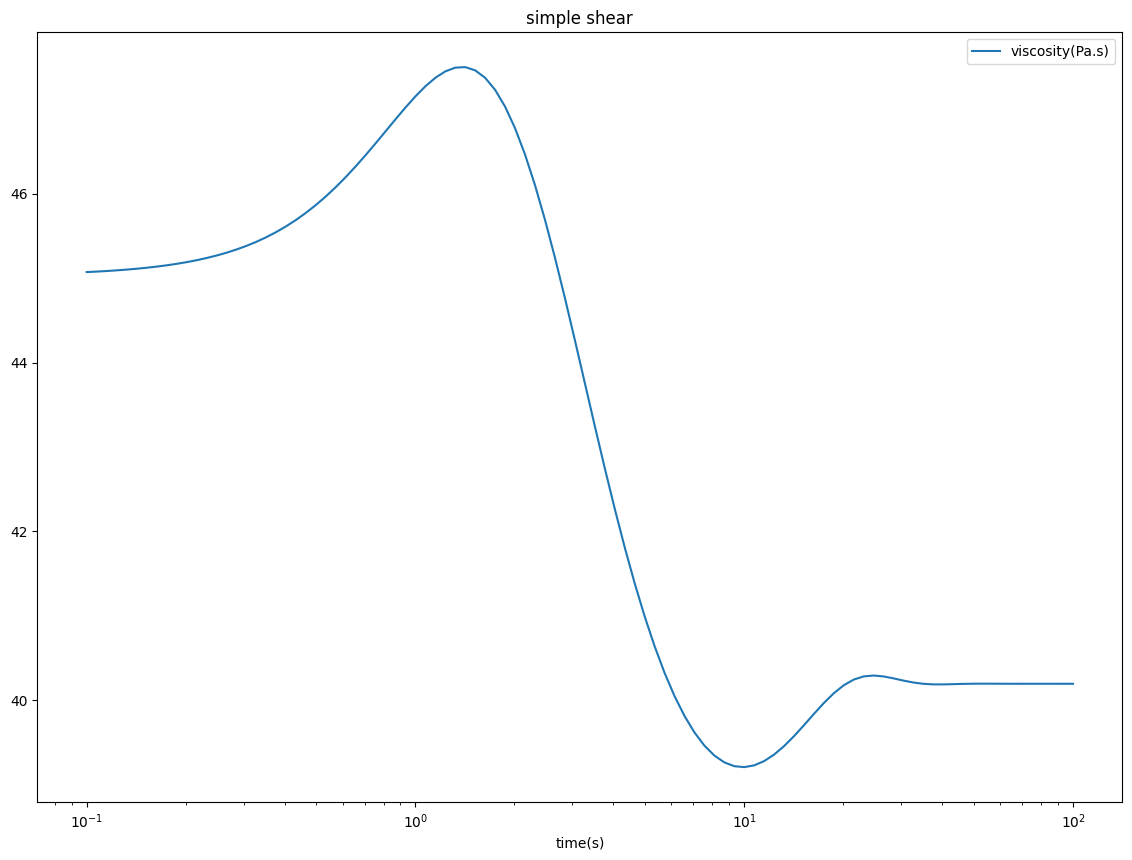

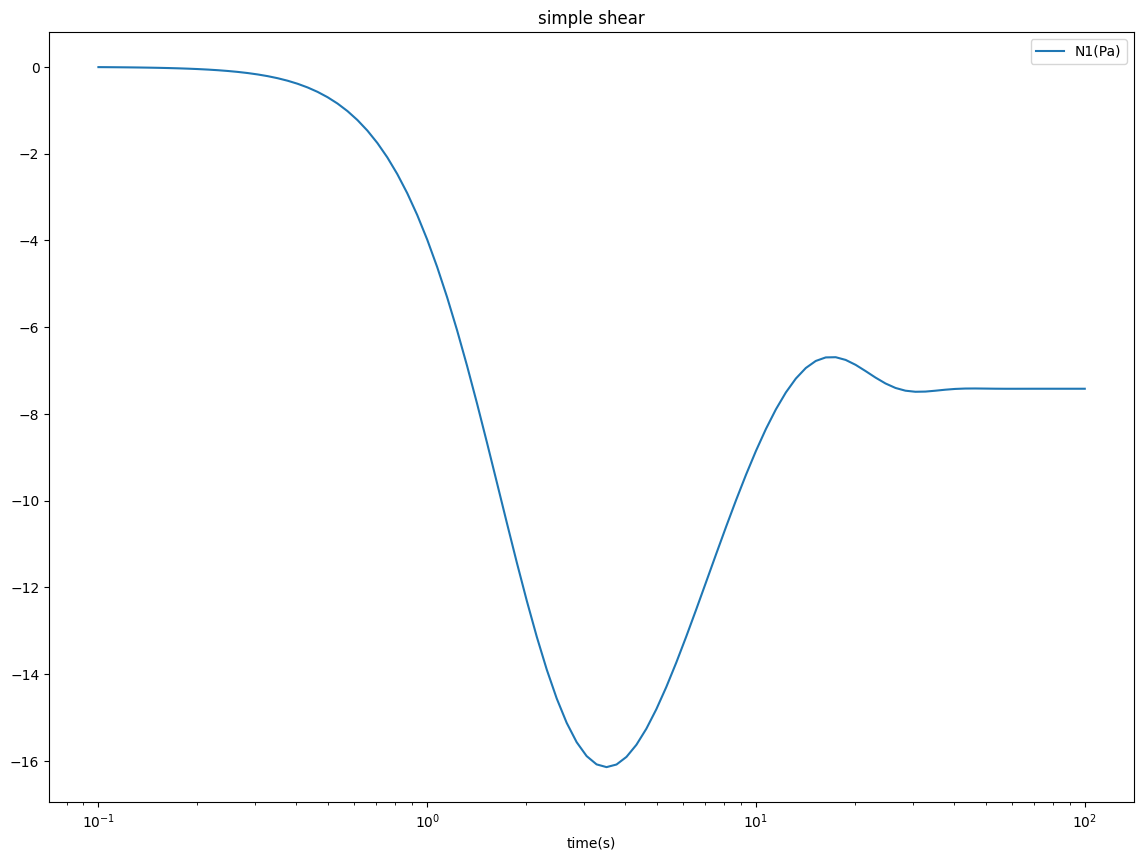

In [2]:
#####################################
#parameters
shear_rate=1
Yc=1/6
phi=0.1
k=0.3
rho=320/16
viscosity_0=35.1
q=0.5
XA=1
######################################
#forward shear
#initial state: random orientation
a2_0=np.eye(3)/3
#velocity gradient
L=np.zeros([3,3])
L[0,1]=shear_rate
#ODE function
fun=partial(models.Ferec_model.da2_fun_for_ode,L=L,k=k,phi=phi,q=q,Yc=Yc)
t_span=(0,100)
t_eval=np.logspace(-1,np.log10(t_span[1]),num=100)
res=integrate.solve_ivp(fun,t_span,a2_0.reshape((-1,)),method='RK45',t_eval=t_eval,max_step=1,rtol=1e-6,atol=1e-8)
#store the results in pandas
res_df=pd.DataFrame(res.y.T,index=res.t,columns=['Axx','Axy','Axz',\
                                                'Ayx','Ayy','Ayz',\
                                                'Azx','Azy','Azz'])
res_df.index.name='time(s)'

#calculate the viscosity and normal force
for ind,row in res_df.iterrows():
    a2=np.reshape(row.values[:9],[3,3])
    a4=models.a4_IBOF.a4_IBOF(a2)
    #a4=models.a4_ORW3.a4_ORW3(a2)
    b2=3*np.pi/8*(a2-np.tensordot(a4,a2,axes=([2,3],[1,0])))
    f=np.trace(b2)
    res_df.loc[ind,'f']=f
    sigma=models.Ferec_model.stress(viscosity_0,L=L,rho=rho,phi=phi,k=k,a2=a2,XA=XA)
    res_df.loc[ind,'viscosity(Pa.s)']=sigma[0,1]/shear_rate
    res_df.loc[ind,'N1(Pa)']=sigma[1,1]-sigma[0,0]
#plot results
res_df.plot(y=['Axx','Axy','Ayy','f'],title='simple shear',figsize=(8,6),logx=True,)
res_df.plot(y=['viscosity(Pa.s)'],title='simple shear',figsize=(14,10),logx=True,)
res_df.plot(y=['N1(Pa)'],title='simple shear',figsize=(14,10),logx=True,)